In [6]:
import h5py

In [9]:
import tensorflow as tf
from tensorflow import keras

--2023-05-29 08:34:43--  https://github.com/Mercy-Kamau/pcos-detection-model/blob/main/SavedModel/model.h5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘model.h5’

model.h5                [ <=>                ] 137.87K  --.-KB/s    in 0.05s   

2023-05-29 08:34:44 (2.65 MB/s) - ‘model.h5’ saved [141181]



In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!ls -lh drive/MyDrive/data

total 8.0K
drwx------ 4 root root 4.0K May 29 06:06 test
drwx------ 4 root root 4.0K May 29 06:06 train


In [15]:
!pip3 install lime
from lime import lime_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=c2ca324df4a5e9a2eb86afe00b62dc3319bf6f8c383d3ddd0a755199bf068f57
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [23]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

train_folder = "drive/MyDrive/data/train"
test_folder = "drive/MyDrive/data/test"
image_size = (220, 220)  # Specify the desired image size


def load_and_resize_images_from_folder(folder, image_size):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path, 0)  # Load images in grayscale
                    if img is not None:
                        img = cv2.resize(img, image_size)  # Resize images
                        images.append(img)
                        labels.append(subfolder)
    return images, labels

train_images, train_labels = load_and_resize_images_from_folder(train_folder, image_size)

test_images, test_labels = load_and_resize_images_from_folder(test_folder, image_size)

label_mapping = {'infected': 0, 'notinfected': 1}
train_labels = [label_mapping[label] for label in train_labels]
test_labels = [label_mapping[label] for label in test_labels]

X_train = np.array(train_images)
X_test = np.array(test_images)
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_val = tf.convert_to_tensor(Y_val, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (1539, 220, 220, 1)
Y_train shape: (1539,)
X_val shape: (385, 220, 220, 1)
Y_val shape: (385,)
X_test shape: (1922, 220, 220, 1)
Y_test shape: (1922,)


In [24]:
import tensorflow as tf
from tensorflow.keras import layers

# Defining Model
model = tf.keras.Sequential()

# Adding Convolutional Layers
model.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(220, 220, 1)))
model.add(layers.MaxPooling2D((6, 6)))

model.add(layers.Conv2D(12, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((6, 6)))

model.add(layers.Conv2D(10, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Adding dropout layer
model.add(layers.Dropout(0.5))

# Flatten the output
model.add(layers.Flatten())

# Adding dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 216, 216, 16)      416       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 12)        4812      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 12)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 10)          1090      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 10)        

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val, Y_val))

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X_train, Y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
49/49 [==============================] - 61s 1s/step - loss: 0.6527 - accuracy: 0.6459 - val_loss: 0.5884 - val_accuracy: 0.6623
Epoch 2/10
49/49 [==============================] - 51s 1s/step - loss: 0.4393 - accuracy: 0.8044 - val_loss: 0.1678 - val_accuracy: 0.9870
Epoch 3/10
49/49 [==============================] - 56s 1s/step - loss: 0.1793 - accuracy: 0.9220 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 4/10
49/49 [==============================] - 51s 1s/step - loss: 0.0983 - accuracy: 0.9500 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 5/10
49/49 [==============================] - 56s 1s/step - loss: 0.0672 - accuracy: 0.9591 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/10
49/49 [==============================] - 48s 980ms/step - loss: 0.0459 - accuracy: 0.9786 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 7/10
49/49 [==============================] - 50s 1s/step - loss: 0.0451 - accuracy: 0.9760 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 8/10
49/49 

In [26]:
import numpy as np

random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
random_label = Y_test[random_index]

random_image = np.expand_dims(random_image, axis=0)

prediction = model.predict(random_image)

predicted_label = "notinfected" if prediction > 0.5 else "infected"

print("True Label:", "notinfected" if random_label > 0.5 else "infected")
print("Predicted Label:", predicted_label)


1/1 [==============================] - 0s 232ms/step
True Label: notinfected
Predicted Label: notinfected


In [35]:
model.save("saved_model.h5")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 177ms/step


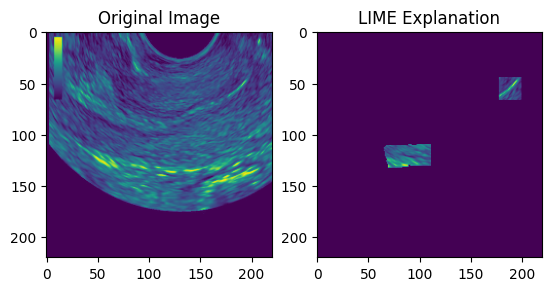

In [53]:
import numpy as np
from keras.models import load_model
import lime
import lime.lime_image
from skimage.segmentation import slic

# Load the trained CNN model
model_path = 'saved_model.h5'
model = load_model(model_path)

random_index = np.random.randint(0, len(X_test))
random_image = X_test[random_index]
random_label = Y_test[random_index]

# Convert the image to a NumPy array
random_image = random_image.numpy()

explainer = lime.lime_image.LimeImageExplainer()

segmenter = lambda img: slic(img, n_segments=100, compactness=1)

explanation = explainer.explain_instance(
    random_image,
    classifier_fn=model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmenter
)

lime_exp = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

# Displaying the image and LIME explanation
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(random_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(lime_exp[0])
plt.title('LIME Explanation')

plt.show()
